## 使用深度学习方法进行建模
#### LSTM （长短期记忆网络）

In [1]:
import pandas as pd
import numpy as np

data=pd.read_csv("encoded_dataset.csv")
data.dropna(inplace=True)
print(data.head(2))
# data

# 查看数据类型
print(data.dtypes)
print("shape:", data.shape)

   Address    Rent  Beds  Baths  Type  Area_in_sqft  Rent_per_sqft  \
0     3905  124000     3      4     0          1785      69.467787   
1     4219  140000     3      4     0          1422      98.452883   

   Rent_category  Frequency  Furnishing  Purpose  Posted_date  \
0              2          0           1        0          503   
1              2          0           1        0          504   

   Age_of_listing_in_days  Location  City   Latitude  Longitude  
0                      45       135     0  24.493598  54.407841  
1                      44       353     0  24.494022  54.607372  
Address                     int64
Rent                        int64
Beds                        int64
Baths                       int64
Type                        int64
Area_in_sqft                int64
Rent_per_sqft             float64
Rent_category               int64
Frequency                   int64
Furnishing                  int64
Purpose                     int64
Posted_date          

In [2]:
# 准备特征和目标变量
X = data.drop(['Rent'],  axis=1)
y = data['Rent']
# # 根据分类剔除分类为1的维度
# X = X.drop(['Frequency', 'Purpose'], axis=1)
print(X.head(2))
print("*************************************")
print(y.head(2))

   Address  Beds  Baths  Type  Area_in_sqft  Rent_per_sqft  Rent_category  \
0     3905     3      4     0          1785      69.467787              2   
1     4219     3      4     0          1422      98.452883              2   

   Frequency  Furnishing  Purpose  Posted_date  Age_of_listing_in_days  \
0          0           1        0          503                      45   
1          0           1        0          504                      44   

   Location  City   Latitude  Longitude  
0       135     0  24.493598  54.407841  
1       353     0  24.494022  54.607372  
*************************************
0    124000
1    140000
Name: Rent, dtype: int64


In [3]:
from sklearn.preprocessing import StandardScaler
# 使用标准归一化器
standard_scaler = StandardScaler()
X_scaled = standard_scaler.fit_transform(X)

print(X_scaled[:2])
print(X_scaled.shape)
print(y.shape)

[[ 1.47687015  0.5381336   0.83981347 -0.53658716 -0.08421462 -0.28621261
   1.20988169  0.          0.52157908  0.          0.43296941 -0.40208572
  -0.84502384 -1.18090496 -0.74704453 -0.98711226]
 [ 1.72925982  0.5381336   0.83981347 -0.53658716 -0.20618471  0.14882219
   1.20988169  0.          0.52157908  0.          0.44833278 -0.41600607
   1.69240706 -1.18090496 -0.7463     -0.68188639]]
(73023, 16)
(73023,)


In [4]:
# 归一化正确，将y也归一化处理
y_from_to_frame = y.to_frame()
print(y_from_to_frame.shape)
y_scaled = standard_scaler.fit_transform(y_from_to_frame)
print(y_scaled[:2])

(73023, 1)
[[-0.07906335]
 [-0.02715964]]


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
# 划分数据集
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.1, random_state=42) # 批量归一化
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test)

print(X_train_tensor[:3].numpy())
print("训练集特征张量大小", X_train_tensor.size())
print("训练集目标张量大小", y_train_tensor.size())
print("测试集目标张量大小:", X_test_tensor.size())
print("测试集目标张量大小:", y_test_tensor.size())

[[ 0.26395294 -1.3711756  -1.0110441  -0.5365872  -0.46558115 -0.47449508
  -0.0099224   0.          0.5215791   0.          0.5251496  -0.48560783
  -1.694714   -1.180905   -0.78964376 -1.0774182 ]
 [ 1.6480771  -1.3711756  -0.3940916  -0.5365872  -0.52505416  1.6856266
   1.2098817   0.         -1.9172548   0.          0.01815861 -0.02623618
  -0.12336918  0.35166693  0.4750966   0.3238181 ]
 [-1.1756327   0.5381336   0.8398135  -0.5365872   0.46280274 -0.2734313
  -1.2297266   0.          0.5215791   0.         -1.8100816   1.6302859
  -1.0196177  -1.180905   -0.7605115  -0.6917267 ]]
训练集特征张量大小 torch.Size([65720, 16])
训练集目标张量大小 torch.Size([65720, 1])
测试集目标张量大小: torch.Size([7303, 16])
测试集目标张量大小: torch.Size([7303, 1])


In [6]:
# 设置硬件
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
    
# 将数据也送到GPU
X_train_tensor_gpu = X_train_tensor.to(device)
X_test_tensor_gpu = X_test_tensor.to(device)
y_train_tensor_gpu = y_train_tensor.to(device)
y_test_tensor_gpu = y_test_tensor.to(device)

from torch.utils.data import DataLoader
# 创建数据加载器，指定批量大小
batch_size = 32
train_dataset = torch.utils.data.TensorDataset(X_train_tensor_gpu, y_train_tensor_gpu)
test_dataset = torch.utils.data.TensorDataset(X_test_tensor_gpu, y_test_tensor_gpu)
train_data_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_data_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)  # 关闭打乱

In [7]:
# 构建LSTM
class RentPredictor_LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(RentPredictor_LSTM, self).__init__()
        self.hidden_size = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # x 的形状是 (batch_size, feature_dim)
        # 由于我们的数据是二维的，我们需要添加一个序列长度维度
        x = x.unsqueeze(1)  # 现在形状变为 (batch_size, 1, feature_dim)
        
        # 初始化隐藏状态和细胞状态
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # 前向传播LSTM
        out, _ = self.lstm(x, (h0, c0))
        
        # 解码最后一个时间步的隐藏状态
        out = self.fc(out[:, -1, :])
        return out

In [8]:
# 定义LSTM模型的参数
hidden_dim = 128  # 隐藏层的维度
num_layers = 4   # LSTM层的数量
output_dim = 1  # 输出的维度

print(X_train_tensor.shape[1])
# 实例化模型
model = RentPredictor_LSTM(input_dim=X_train_tensor.shape[1], 
						   hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
model.to(device)

# 定义损失函数
criterion = nn.MSELoss()
# 定义优化器
optimizer = optim.AdamW(model.parameters(), lr=0.0001, betas=(0.9, 0.999), weight_decay=0.01)
# 定义训练轮数
epochs = 100

16


d:\ProgramData\anaconda3\envs\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
from sklearn.metrics import mean_squared_error, r2_score

# 存储训练log
loss_values = []
MSE_values = []
RMSE_values = []
sMAPE_values = []

# 训练模型
for epoch in range(epochs):
    # 训练模式
    model.train()
    for batch in train_data_loader:
        X_batch, y_batch = batch
        optimizer.zero_grad()
        # 前向传播
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        # 反向传播
        loss.backward()
        optimizer.step()
    loss_values.append(loss.item())
    if (epoch + 1) % 5 == 0:
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')
    
    # 评估模式
    model.eval()
    with torch.no_grad():
        y_val_pred = model(X_test_tensor.to(device))
        # 将预测结果从GPU复制到CPU
        y_val_pred_cpu = y_val_pred.to('cpu')
        # 将预测结果转换为Numpy数组
        y_val_pred_numpy = y_val_pred_cpu.numpy()
        # 安全地使用y_val_pred_numpy作为mean_squared_error的输入
        MSE_lr = mean_squared_error(y_test, y_val_pred_numpy)
        RMSE_lr = np.sqrt(MSE_lr)
        
		# 计算sMAPE
        abs_diff = np.abs(y_test - y_val_pred_numpy)
        avg_abs = (np.abs(y_test) + np.abs(y_val_pred_numpy)) / 2
        sMAPE = np.mean((abs_diff / avg_abs) * 100)
        
        MSE_values.append(MSE_lr)
        RMSE_values.append(RMSE_lr)
        sMAPE_values.append(sMAPE)

Epoch 5/100, Loss: 0.0038357870653271675
Epoch 10/100, Loss: 0.0010541954543441534
Epoch 15/100, Loss: 0.001726357964798808
Epoch 20/100, Loss: 0.002380837220698595
Epoch 25/100, Loss: 0.00044640092528425157
Epoch 30/100, Loss: 0.00021587192895822227
Epoch 35/100, Loss: 0.0022698398679494858
Epoch 40/100, Loss: 0.00021851769997738302
Epoch 45/100, Loss: 0.0006255285697989166
Epoch 50/100, Loss: 0.0018240574281662703
Epoch 55/100, Loss: 0.00027740278164856136
Epoch 60/100, Loss: 0.0037743686698377132
Epoch 65/100, Loss: 7.995901250978932e-05
Epoch 70/100, Loss: 0.00015997876471374184
Epoch 75/100, Loss: 5.869239248568192e-05
Epoch 80/100, Loss: 0.00024114297411870211
Epoch 85/100, Loss: 3.808160909102298e-05
Epoch 90/100, Loss: 5.685600626748055e-05
Epoch 95/100, Loss: 0.0004961213562637568
Epoch 100/100, Loss: 0.0013810200616717339


In [10]:
# 查看模型参数
for name, param in model.named_parameters():
    print(f"{name}:", param.size())

lstm.weight_ih_l0: torch.Size([512, 16])
lstm.weight_hh_l0: torch.Size([512, 128])
lstm.bias_ih_l0: torch.Size([512])
lstm.bias_hh_l0: torch.Size([512])
lstm.weight_ih_l1: torch.Size([512, 128])
lstm.weight_hh_l1: torch.Size([512, 128])
lstm.bias_ih_l1: torch.Size([512])
lstm.bias_hh_l1: torch.Size([512])
lstm.weight_ih_l2: torch.Size([512, 128])
lstm.weight_hh_l2: torch.Size([512, 128])
lstm.bias_ih_l2: torch.Size([512])
lstm.bias_hh_l2: torch.Size([512])
lstm.weight_ih_l3: torch.Size([512, 128])
lstm.weight_hh_l3: torch.Size([512, 128])
lstm.bias_ih_l3: torch.Size([512])
lstm.bias_hh_l3: torch.Size([512])
fc.weight: torch.Size([1, 128])
fc.bias: torch.Size([1])


In [11]:
# 获取模型的所有参数
parameters = list(model.parameters())

# 将所有参数打包成一个向量
parameters_vector = torch.cat([p.view(-1) for p in parameters])

# 计算参数量
num_parameters = parameters_vector.numel()

print(f"The model has {num_parameters} parameters.")

The model has 471169 parameters.


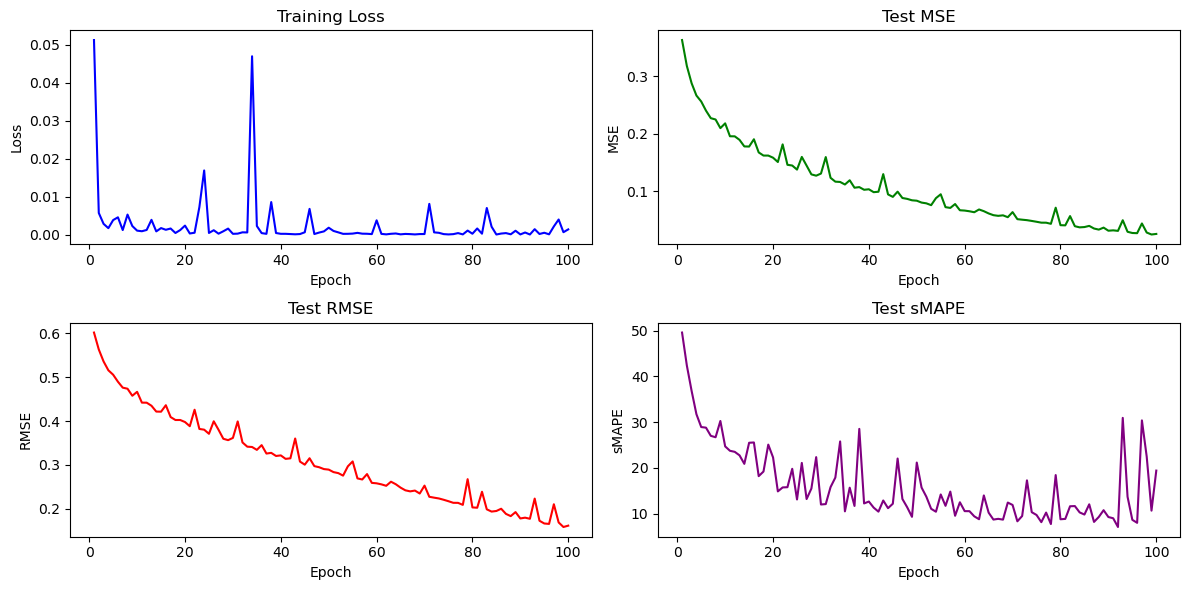

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# 绘制2x2的图表矩阵
plt.figure(figsize=(12, 6))

# 绘制训练损失曲线
ax1 = plt.subplot(2, 2, 1)
plt.plot(range(1, epochs + 1), loss_values, label='Training Loss', color='blue')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# 绘制MSE曲线
ax2 = plt.subplot(2, 2, 2)
plt.plot(range(1, epochs + 1), MSE_values, label='Test MSE', color='green')
plt.title('Test MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')

# 绘制RMSE曲线
ax3 = plt.subplot(2, 2, 3)
plt.plot(range(1, epochs + 1), RMSE_values, label='Test RMSE', color='red')
plt.title('Test RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE')

# 绘制sMAPE曲线
ax4 = plt.subplot(2, 2, 4)
plt.plot(range(1, epochs + 1), sMAPE_values, label='Test sMAPE', color='purple')
plt.title('Test sMAPE')
plt.xlabel('Epoch')
plt.ylabel('sMAPE')

# 调整布局并显示图表
plt.tight_layout()
plt.show()

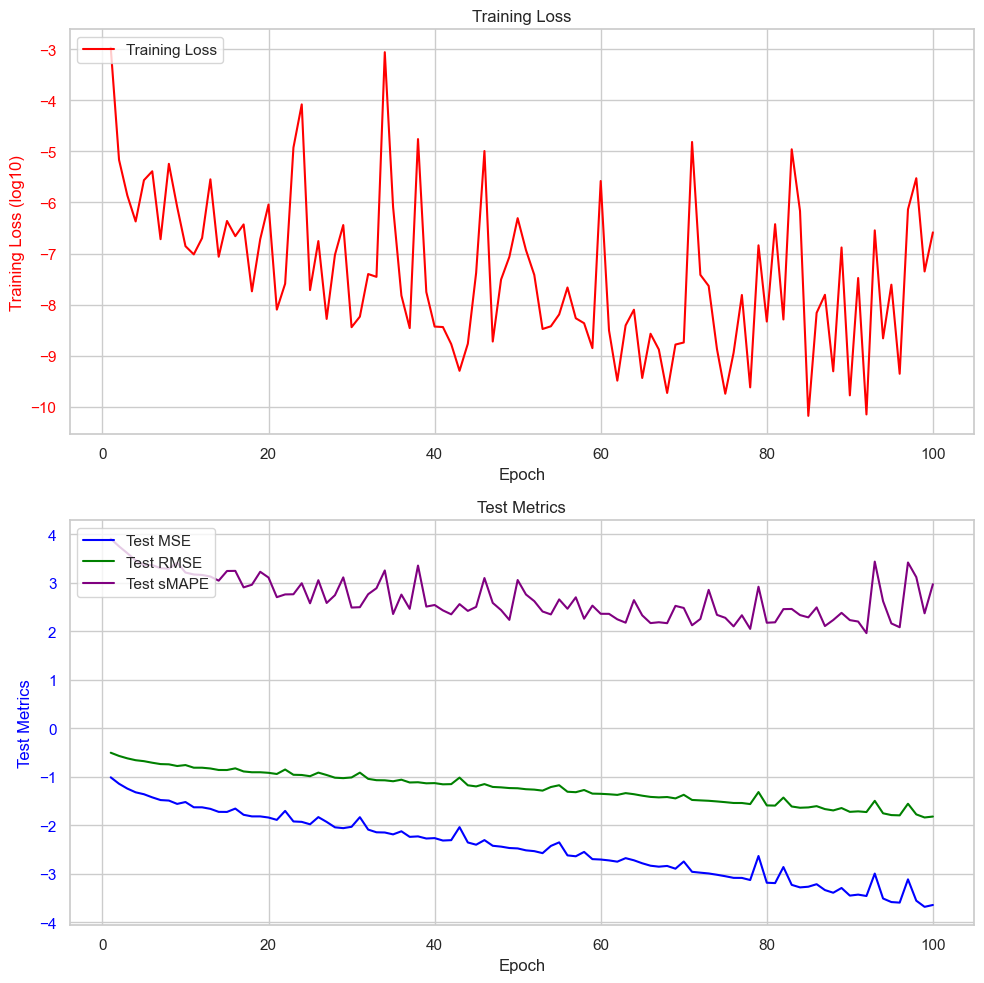

In [13]:
# 重绘可视化数据
# 设置seaborn样式
sns.set(style="whitegrid")

# 创建一个图和两个轴用于绘制训练损失和其他指标
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))

# 对数变换
log_loss_values = np.log(loss_values)
# 绘制训练损失曲线
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Training Loss (log10)', color='red')
ax1.plot(range(1, len(log_loss_values) + 1), log_loss_values, label='Training Loss', color='red')
ax1.tick_params(axis='y', labelcolor='red')
ax1.legend(loc='upper left')

# 对数变换
log_MSE_values = np.log(MSE_values)
log_RMSE_values = np.log(RMSE_values)
log_sMAPE_values = np.log(sMAPE_values)
# 绘制指标曲线
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Test Metrics', color='blue')
ax2.plot(range(1, epochs + 1), log_MSE_values, label='Test MSE', color='blue')
ax2.plot(range(1, epochs + 1), log_RMSE_values, label='Test RMSE', color='green')
ax2.plot(range(1, epochs + 1), log_sMAPE_values, label='Test sMAPE', color='purple')
ax2.tick_params(axis='y', labelcolor='blue')
ax2.legend(loc='upper left')

# 添加标题
ax1.set_title('Training Loss')
ax2.set_title('Test Metrics')

# 显示图表
plt.tight_layout()
plt.show()

In [14]:
model.eval()
with torch.no_grad():
    y_val_pred = model(X_test_tensor.to(device))
    
# 将预测结果从GPU复制到CPU
y_val_pred_cpu = y_val_pred.to('cpu')

# 将预测结果转换为Numpy数组
y_val_pred_numpy = y_val_pred_cpu.numpy()

# 安全地使用y_val_pred_numpy作为mean_squared_error的输入
MSE_lr = mean_squared_error(y_test, y_val_pred_numpy)
RMSE_lr = np.sqrt(MSE_lr)
r2_lr = r2_score(y_test, y_val_pred_numpy)

# 计算sMAPE
abs_diff = np.abs(y_test - y_val_pred_numpy)
avg_abs = (np.abs(y_test) + np.abs(y_val_pred_numpy)) / 2
sMAPE = np.mean((abs_diff / avg_abs) * 100)

# 打印指标
print(f'Test MSE: {MSE_lr}')
print(f'Test RMSE: {RMSE_lr}')
print(f'Test R²: {r2_lr}')
print(f'Test sMAPE: {sMAPE}')

Test MSE: 0.026098755817407237
Test RMSE: 0.1615510935196888
Test R²: 0.9725186595442654
Test sMAPE: 19.40900784160638


In [15]:
# 选择测试集中的几个样本
X_test_sample = X_test_tensor_gpu[:5]  # 选择前5个样本
y_test_sample = y_test_tensor_gpu[:5]

# 使用模型进行预测
with torch.no_grad():  # 确保不计算梯度
    y_pred_sample = model(X_test_sample)

# 将预测结果和实际目标值转换为 NumPy 数组
y_pred_sample_np = y_pred_sample.cpu().numpy()
y_test_sample_np = y_test_sample.cpu().numpy()

# 反归一化
y_pred_original = standard_scaler.inverse_transform(y_pred_sample_np)
y_test_original = standard_scaler.inverse_transform(y_test_sample_np)

# 打印反归一化后的预测结果和实际目标值
print('反归一化后的预测结果:', y_pred_original)
print('反归一化后的实际目标值:', y_test_original)

反归一化后的预测结果: [[248660.72 ]
 [ 42150.574]
 [ 97275.61 ]
 [134378.92 ]
 [141407.6  ]]
反归一化后的实际目标值: [[230000.   ]
 [ 45000.004]
 [ 90000.   ]
 [135000.   ]
 [135000.   ]]


In [16]:
import datetime
# 保存模型

# 获取当前日期和时间
current_time = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')

# 结合模型名称和日期时间
model_name = 'LSTM_Standard_Adamw'
model_file_name = f"pre_models/LSTM/{model_name}_R{r2_lr:.3f}_B{batch_size}_S{sMAPE:.1f}.pth"

# 保存模型
torch.save(model, model_file_name)

print(f"Model saved as {model_file_name}")

Model saved as pre_models/LSTM/LSTM_Standard_Adamw_R0.973_B32_S19.4.pth
